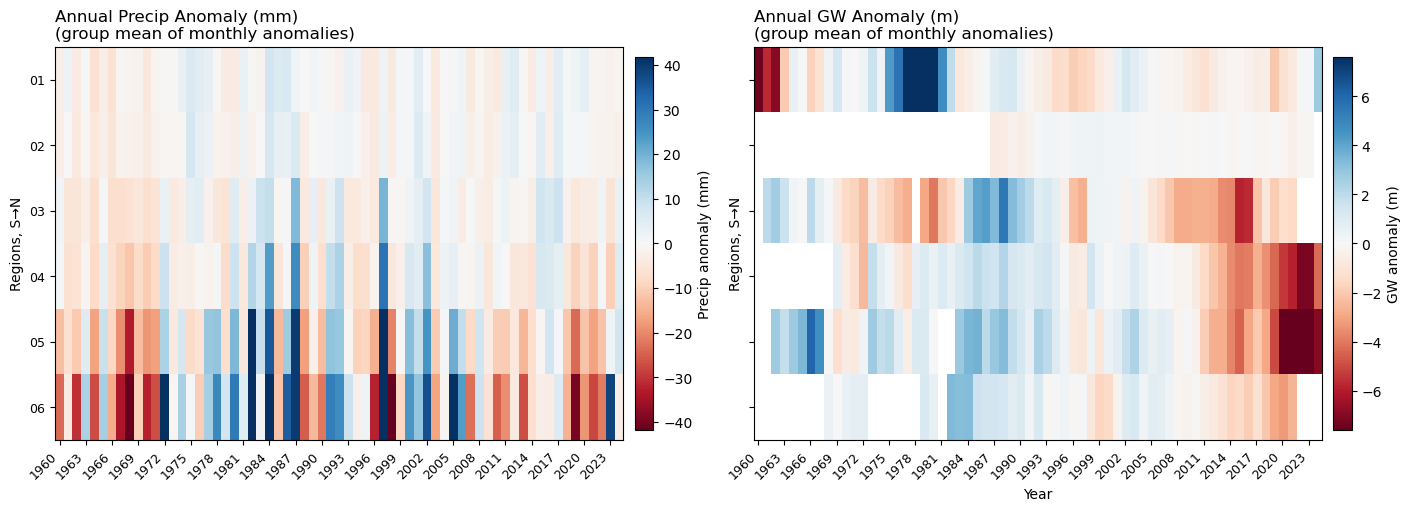

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib import gridspec

# -------------------- Paths & params --------------------
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
out_figs = root + '/2_GW_memory_pred_pos'
os.makedirs(out_figs, exist_ok=True)

min_obs = 100  # minimum monthly GW observations required per well

# -------------------- Load monthly anomalies --------------------
gw_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_gw_an.csv', parse_dates=['date'])
pr_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_pr_an.csv', parse_dates=['date'])

gw_m = gw_an_all.set_index('date')
pr_m = pr_an_all.set_index('date')

# -------------------- Filter wells by GW obs count --------------------
gw_counts = gw_m.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= min_obs].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the min_obs criterion.")

# use only wells present in both datasets
common_wells = [w for w in keep_wells if w in pr_m.columns]
gw_m = gw_m[common_wells]
pr_m = pr_m[common_wells]

# -------------------- Helper: group label from well code --------------------
def well_group(code: str) -> str:
    # first two digits as string; fallback "99" if unexpected format
    try:
        return f"{int(str(code)[:2]):02d}"
    except Exception:
        return "99"

# map wells -> groups (first two digits)
well_groups = {w: well_group(w) for w in common_wells}
groups_sorted = sorted({well_groups[w] for w in common_wells}, key=lambda x: int(x))

# -------------------- Monthly → Annual anomalies (mean over months) --------------------
gw_y = gw_m.resample('A-DEC').mean()
pr_y = pr_m.resample('A-DEC').mean()

gw_y.index = gw_y.index.year
pr_y.index = pr_y.index.year

# shared years for a common X axis
years = sorted(set(gw_y.index).intersection(set(pr_y.index)))
gw_y = gw_y.loc[years]
pr_y = pr_y.loc[years]

# -------------------- Aggregate across wells within each group --------------------
# Make a MultiIndex by group/well to groupby on level=0 (group)
gw_y.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in gw_y.columns], names=['group', 'well'])
pr_y.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in pr_y.columns], names=['group', 'well'])

# Mean across wells per group (skip NaNs)
gw_grp = gw_y.groupby(level='group', axis=1).mean()
pr_grp = pr_y.groupby(level='group', axis=1).mean()

# Reindex columns to consistent north→south order; ensure same set of groups
all_groups = sorted(set(gw_grp.columns).union(set(pr_grp.columns)), key=lambda x: int(x))
gw_grp = gw_grp.reindex(columns=all_groups)
pr_grp = pr_grp.reindex(columns=all_groups)

# -------------------- Build matrices for heatmaps --------------------
year_vals = np.array(years)
group_labels = all_groups  # rows

# shape: (n_groups, n_years)
gw_mat = gw_grp.values.T
pr_mat = pr_grp.values.T

# -------------------- Color scaling (symmetric around 0, robust) --------------------
def robust_sym_norm(arr, pct=98):
    a = np.abs(arr[np.isfinite(arr)])
    m = np.percentile(a, pct) if a.size else 1.0
    if m == 0: m = 1.0
    return TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

pr_norm = robust_sym_norm(pr_mat)
gw_norm = robust_sym_norm(gw_mat)

# -------------------- Plot (1 row, 2 columns using subplots) --------------------
fig, (ax_pr, ax_gw) = plt.subplots(
    1, 2, figsize=(14, 5),
    constrained_layout=True,
    sharex=True, sharey=True
)

# Precip (% anomalies, left)
im_pr = ax_pr.imshow(
    pr_mat, aspect='auto', interpolation='nearest',
    cmap='RdBu', norm=pr_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5,
            len(group_labels) - 0.5, -0.5]
)
ax_pr.set_title('Annual Precip Anomaly (mm)\n(group mean of monthly anomalies)', loc='left')
ax_pr.set_ylabel('Regions, S→N')

if len(year_vals) > 20:
    step = max(1, len(year_vals) // 20)
    xticks = year_vals[::step]
else:
    xticks = year_vals
ax_pr.set_xticks(xticks)
ax_pr.set_xticklabels(xticks, rotation=45, ha='right', fontsize=9)
ax_pr.set_yticks(np.arange(len(group_labels)))
ax_pr.set_yticklabels(group_labels, fontsize=9)

cb_pr = fig.colorbar(im_pr, ax=ax_pr, location='right', pad=0.02, shrink=0.95)
cb_pr.set_label('Precip anomaly (mm)')

# Groundwater (absolute anomalies, right)
im_gw = ax_gw.imshow(
    gw_mat, aspect='auto', interpolation='nearest',
    cmap='RdBu', norm=gw_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5,
            len(group_labels) - 0.5, -0.5]
)
ax_gw.set_title('Annual GW Anomaly (m)\n(group mean of monthly anomalies)', loc='left')
ax_gw.set_xlabel('Year')
ax_gw.set_ylabel('Regions, S→N')
ax_gw.set_xticks(xticks)
ax_gw.set_xticklabels(xticks, rotation=45, ha='right', fontsize=9)
ax_gw.set_yticks(np.arange(len(group_labels)))
ax_gw.set_yticklabels(group_labels, fontsize=9)

cb_gw = fig.colorbar(im_gw, ax=ax_gw, location='right', pad=0.02, shrink=0.95)
cb_gw.set_label('GW anomaly (m)')

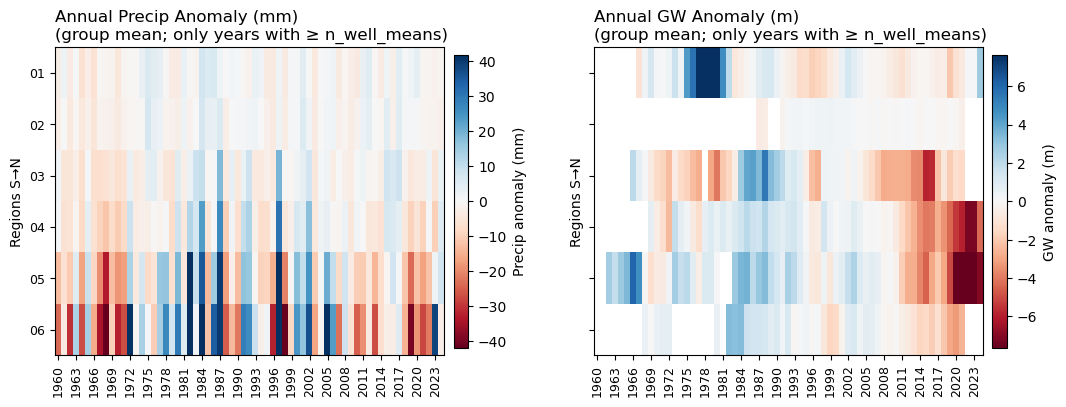

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# -------------------- Paths & params --------------------
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
out_figs = root + '/2_GW_memory_pred_pos'
os.makedirs(out_figs, exist_ok=True)

obs_min = 100        # min monthly GW observations required per well (overall)
n_well_means = 5     # min number of wells required per group-year to compute the annual mean

# -------------------- Load monthly anomalies --------------------
gw_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_gw_an.csv', parse_dates=['date'])
pr_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_pr_an.csv', parse_dates=['date'])

gw_m = gw_an_all.set_index('date')  # monthly GW anomalies (m)
pr_m = pr_an_all.set_index('date')  # monthly P anomalies (mm)

# -------------------- Filter wells by GW obs count (overall) --------------------
gw_counts = gw_m.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= obs_min].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the obs_min criterion.")

# keep only wells present in both datasets
common_wells = [w for w in keep_wells if w in pr_m.columns]
gw_m = gw_m[common_wells]
pr_m = pr_m[common_wells]

# -------------------- Helper: group label from well code --------------------
def well_group(code: str) -> str:
    try:
        return f"{int(str(code)[:2]):02d}"
    except Exception:
        return "99"

well_groups = {w: well_group(w) for w in common_wells}
groups_sorted = sorted({well_groups[w] for w in common_wells}, key=lambda x: int(x))

# -------------------- Monthly → Annual (mean over months) --------------------
gw_y = gw_m.resample('A-DEC').mean()   # annual mean GW anomaly per well (m)
pr_y = pr_m.resample('A-DEC').mean()   # annual mean P anomaly per well (mm)

gw_y.index = gw_y.index.year
pr_y.index = pr_y.index.year

# align years
years = sorted(set(gw_y.index).intersection(set(pr_y.index)))
gw_y = gw_y.loc[years]
pr_y = pr_y.loc[years]

# -------------------- Assign group to columns and compute group means --------------------
# MultiIndex columns (group, well)
gw_y.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in gw_y.columns], names=['group', 'well'])
pr_y.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in pr_y.columns], names=['group', 'well'])

# Annual counts of wells with valid data per group-year
gw_counts_by_group_year = gw_y.groupby(level='group', axis=1).count()
pr_counts_by_group_year = pr_y.groupby(level='group', axis=1).count()

# Group means across wells (skip NaNs)
gw_grp = gw_y.groupby(level='group', axis=1).mean()
pr_grp = pr_y.groupby(level='group', axis=1).mean()

# Mask years where there are < n_well_means valid wells in that group
gw_grp = gw_grp.where(gw_counts_by_group_year >= n_well_means)
pr_grp = pr_grp.where(pr_counts_by_group_year >= n_well_means)

# Consistent N→S column order and same groups in both matrices
all_groups = sorted(set(gw_grp.columns).union(set(pr_grp.columns)), key=lambda x: int(x))
gw_grp = gw_grp.reindex(columns=all_groups)
pr_grp = pr_grp.reindex(columns=all_groups)

# -------------------- Build matrices for heatmaps --------------------
year_vals = np.array(years)
group_labels = all_groups  # rows

# shape: (n_groups, n_years)
gw_mat = gw_grp.values.T
pr_mat = pr_grp.values.T

# -------------------- Color scaling (symmetric around 0, robust) --------------------
def robust_sym_norm(arr, pct=98):
    a = np.abs(arr[np.isfinite(arr)])
    m = np.percentile(a, pct) if a.size else 1.0
    if m == 0:
        m = 1.0
    return TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

pr_norm = robust_sym_norm(pr_mat)
gw_norm = robust_sym_norm(gw_mat)

# -------------------- Plot (1 row, 2 columns using subplots) --------------------
fig, (ax_pr, ax_gw) = plt.subplots(
    1, 2, figsize=(13, 4),
    constrained_layout=False,
    sharex=True, sharey=True
)

fig.subplots_adjust(wspace=0.15) 

# Precip (left)
im_pr = ax_pr.imshow(
    pr_mat, aspect='auto', interpolation='nearest',
    cmap='RdBu', norm=pr_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5,
            len(group_labels) - 0.5, -0.5]
)
ax_pr.set_title('Annual Precip Anomaly (mm)\n(group mean; only years with ≥ n_well_means)', loc='left')
ax_pr.set_ylabel('Regions S→N')

# X ticks
if len(year_vals) > 20:
    step = max(1, len(year_vals) // 20)
    xticks = year_vals[::step]
else:
    xticks = year_vals
ax_pr.set_xticks(xticks)
ax_pr.set_xticklabels(xticks, rotation=90, ha='center', fontsize=9)

# Y ticks
ax_pr.set_yticks(np.arange(len(group_labels)))
ax_pr.set_yticklabels(group_labels, fontsize=9)

cb_pr = fig.colorbar(im_pr, ax=ax_pr, location='right', pad=0.02, shrink=0.95)
cb_pr.set_label('Precip anomaly (mm)')

# Groundwater (right)
im_gw = ax_gw.imshow(
    gw_mat, aspect='auto', interpolation='nearest',
    cmap='RdBu', norm=gw_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5,
            len(group_labels) - 0.5, -0.5]
)
ax_gw.set_title('Annual GW Anomaly (m)\n(group mean; only years with ≥ n_well_means)', loc='left')
# ax_gw.set_xlabel('Year')
ax_gw.set_ylabel('Regions S→N')
ax_gw.set_xticks(xticks)
ax_gw.set_xticklabels(xticks, rotation=90, ha='center', fontsize=9)
ax_gw.set_yticks(np.arange(len(group_labels)))
ax_gw.set_yticklabels(group_labels, fontsize=9)

cb_gw = fig.colorbar(im_gw, ax=ax_gw, location='right', pad=0.02, shrink=0.95)
cb_gw.set_label('GW anomaly (m)')


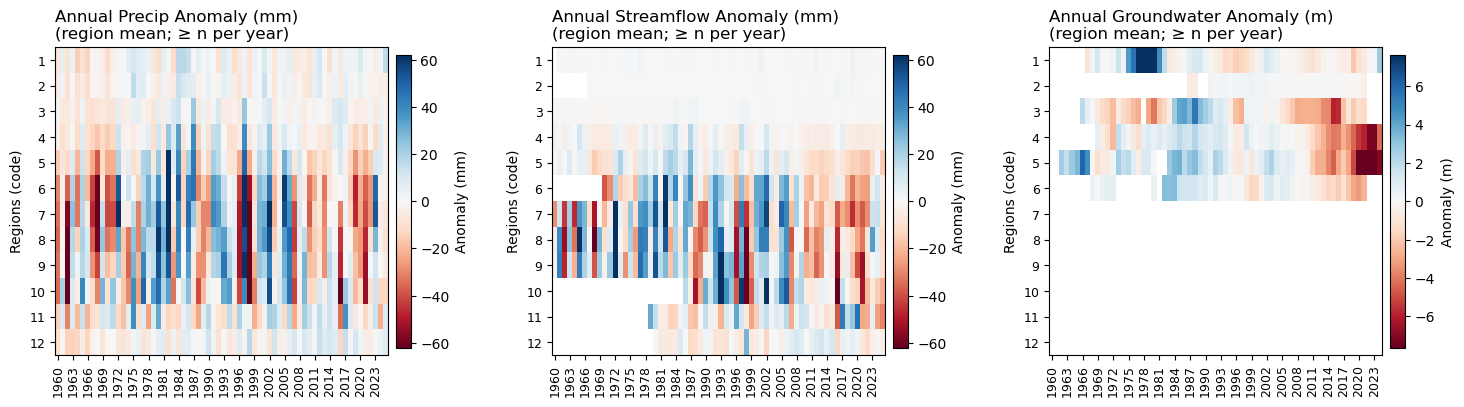

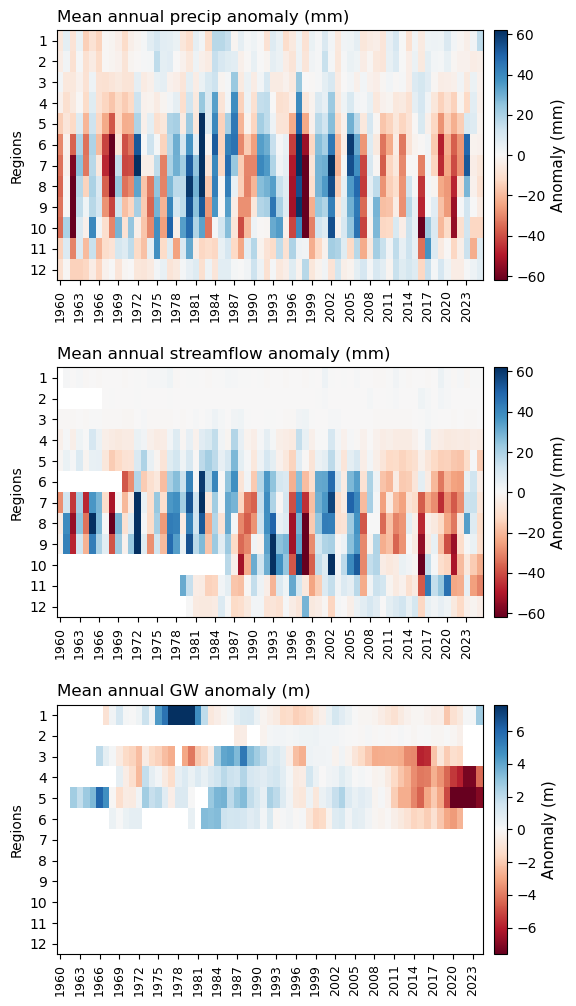

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# -------------------- Paths & params --------------------
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
out_figs = root + '/2_GW_memory_pred_pos'
os.makedirs(out_figs, exist_ok=True)

obs_min = 100        # min monthly observations required per well/station overall
n_well_means = 5     # min # wells/stations required per group-year to compute the annual mean

# -------------------- Region mapping (your rule) --------------------
def extract_region(code):
    s = str(code)
    return int(s[:2]) if len(s) == 8 else int(s[0])

def map_regions(columns):
    regions = {}
    for c in columns:
        try:
            regions[c] = extract_region(c)
        except Exception:
            regions[c] = np.nan
    # drop columns that failed mapping
    regions = {k: v for k, v in regions.items() if pd.notna(v)}
    return regions

# -------------------- Load monthly anomalies (GW & PR tied to wells) --------------------
gw_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_gw_an.csv', parse_dates=['date']).set_index('date')
pr_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_pr_an.csv', parse_dates=['date']).set_index('date')

# -------------------- Filter wells by GW obs count (overall) --------------------
gw_counts = gw_an_all.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= obs_min].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the obs_min criterion.")

# keep only wells present in both datasets
common_wells = [w for w in keep_wells if w in pr_an_all.columns]
gw_m = gw_an_all[common_wells]
# pr_m = pr_an_all[common_wells]

# -------------------- STREAMFLOW (Q): load anomalies, or compute if needed --------------------
q_an_path = os.path.join(root, "data/camels_q_p_et_combined/camels_q_an.csv")
q_an_all = pd.read_csv(q_an_path, parse_dates=['date']).set_index('date')

pr_an_path = os.path.join(root, "data/camels_q_p_et_combined/camels_pr_an.csv")
pr_an_all = pd.read_csv(pr_an_path, parse_dates=['date']).set_index('date')

# Filter streamflow stations by obs_min
q_counts = q_an_all.notna().sum(axis=0)
keep_stations = q_counts[q_counts >= obs_min].index.tolist()
if not keep_stations:
    raise ValueError("No streamflow stations meet the obs_min criterion.")
q_m = q_an_all[keep_stations]
pr_m = pr_an_all[keep_stations]

# -------------------- Monthly → Annual (mean over months) --------------------
gw_y = gw_m.resample('A-DEC').mean()   # annual mean GW anomaly per well (m)
pr_y = pr_m.resample('A-DEC').mean()   # annual mean PR anomaly per well (mm)
q_y  = q_m.resample('A-DEC').mean()    # annual mean Q anomaly per station (units of series)

# convert index to year
for df in (gw_y, pr_y, q_y):
    df.index = df.index.year

# -------------------- Region maps per dataset (YOUR RULE) --------------------
gw_regions = map_regions(gw_y.columns)
pr_regions = map_regions(pr_y.columns)
q_regions  = map_regions(q_y.columns)

# restrict dfs to columns that mapped successfully
gw_y = gw_y[list(gw_regions.keys())]
pr_y = pr_y[list(pr_regions.keys())]
q_y  = q_y[list(q_regions.keys())]

# -------------------- Assign region to columns and compute group means with thresholds --------------------
def groupmean_with_min_count(df_yearly, col2region, min_count):
    # MultiIndex columns: (region, id)
    df_yearly.columns = pd.MultiIndex.from_tuples([(col2region[c], c) for c in df_yearly.columns],
                                                  names=['region', 'id'])
    # count #ids with data per (year, region)
    counts = df_yearly.groupby(level='region', axis=1).count()
    # mean over ids per region
    means  = df_yearly.groupby(level='region', axis=1).mean()
    # mask where insufficient contributing ids
    means  = means.where(counts >= min_count)
    # sort regions ascending (N→S if codes increase southwards)
    means  = means.reindex(columns=sorted(means.columns))
    return means, counts

gw_grp, gw_cnt = groupmean_with_min_count(gw_y, gw_regions, n_well_means)
pr_grp, pr_cnt = groupmean_with_min_count(pr_y, pr_regions, n_well_means)
q_grp,  q_cnt  = groupmean_with_min_count(q_y,  q_regions,  n_well_means)

# -------------------- Harmonize region set and build matrices --------------------
# -------------------- Use the SAME region set for all three (from PR ∪ Q), apply to GW too --------------------
regions_all = sorted(set(pr_grp.columns).union(set(q_grp.columns)))
# If GW has fewer/more, reindex to the common set so y-axis aligns
gw_grp = gw_grp.reindex(columns=regions_all)
pr_grp = pr_grp.reindex(columns=regions_all)
q_grp  = q_grp.reindex(columns=regions_all)

region_labels = [str(r) for r in regions_all]

def to_matrix(df_grp, region_order):
    if df_grp.empty:
        return np.empty((len(region_order), 0))
    df_ord = df_grp.reindex(columns=region_order)
    return df_ord.values.T, df_ord.index.values  # matrix (n_regions, n_years), years

gw_mat, years_gw = to_matrix(gw_grp, regions_all)
pr_mat, years_pr = to_matrix(pr_grp, regions_all)
q_mat,  years_q  = to_matrix(q_grp,  regions_all)

# # -------------------- Color scaling (symmetric, robust per panel) --------------------
# def robust_sym_norm(arr, pct=98):
#     a = np.abs(arr[np.isfinite(arr)])
#     m = np.percentile(a, pct) if a.size else 1.0
#     if m == 0: m = 1.0
#     return TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

# pr_norm = robust_sym_norm(pr_mat)
# q_norm  = robust_sym_norm(q_mat)
# gw_norm = robust_sym_norm(gw_mat)


# -------------------- Color scaling --------------------
def robust_sym_bounds(*arrays, pct=98):
    vals = np.concatenate([a[np.isfinite(a)].ravel() for a in arrays if a.size], axis=0) if arrays else np.array([])
    if vals.size == 0:
        return -1.0, 1.0
    m = np.percentile(np.abs(vals), pct)
    if not np.isfinite(m) or m == 0:
        m = np.max(np.abs(vals)) if vals.size else 1.0
        if m == 0: m = 1.0
    return -m, m

# Shared norm for PR & Q (both in mm)
vmin_pq, vmax_pq = robust_sym_bounds(pr_mat, q_mat, pct=98)
pq_norm = TwoSlopeNorm(vmin=vmin_pq, vcenter=0.0, vmax=vmax_pq)

# Independent norm for GW (m)
vmin_gw, vmax_gw = robust_sym_bounds(gw_mat, pct=98)
gw_norm = TwoSlopeNorm(vmin=vmin_gw, vcenter=0.0, vmax=vmax_gw)


# -------------------- Plot (1×3 panels) --------------------
fig, (ax_pr, ax_q, ax_gw) = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=False)
fig.subplots_adjust(wspace=0.24)

def xticks_for(year_arr):
    if len(year_arr) == 0:
        return np.array([])
    ya = np.array(sorted(np.unique(year_arr)))
    if len(ya) > 20:
        step = max(1, len(ya) // 20)
        return ya[::step]
    return ya

# Precip (mm)
if pr_mat.size:
    im_pr = ax_pr.imshow(
        pr_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=pq_norm,
        extent=[years_pr.min() - 0.5 if len(years_pr) else -0.5,
                years_pr.max() + 0.5 if len(years_pr) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_pr.set_title('Annual Precip Anomaly (mm)\n(region mean; ≥ n per year)', loc='left')
    ax_pr.set_ylabel('Regions (code)')
    ax_pr.set_yticks(np.arange(len(region_labels)))
    ax_pr.set_yticklabels(region_labels, fontsize=9)
    xt = xticks_for(years_pr); ax_pr.set_xticks(xt); ax_pr.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_pr = fig.colorbar(im_pr, ax=ax_pr, location='right', pad=0.02, shrink=0.95)
    cb_pr.set_label('Anomaly (mm)')
else:
    ax_pr.text(0.5, 0.5, 'No PR data', ha='center', va='center'); ax_pr.axis('off')

# Streamflow (mm) — shares color scale with PR
if q_mat.size:
    im_q = ax_q.imshow(
        q_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=pq_norm,
        extent=[years_q.min() - 0.5 if len(years_q) else -0.5,
                years_q.max() + 0.5 if len(years_q) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_q.set_title('Annual Streamflow Anomaly (mm)\n(region mean; ≥ n per year)', loc='left')
    ax_q.set_ylabel('Regions (code)')
    ax_q.set_yticks(np.arange(len(region_labels)))
    ax_q.set_yticklabels(region_labels, fontsize=9)
    xt = xticks_for(years_q); ax_q.set_xticks(xt); ax_q.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_q = fig.colorbar(im_q, ax=ax_q, location='right', pad=0.02, shrink=0.95)
    cb_q.set_label('Anomaly (mm)')
else:
    ax_q.text(0.5, 0.5, 'No Q data', ha='center', va='center'); ax_q.axis('off')

# Groundwater (m) — own scale
if gw_mat.size:
    im_gw = ax_gw.imshow(
        gw_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=gw_norm,
        extent=[years_gw.min() - 0.5 if len(years_gw) else -0.5,
                years_gw.max() + 0.5 if len(years_gw) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_gw.set_title('Annual Groundwater Anomaly (m)\n(region mean; ≥ n per year)', loc='left')
    ax_gw.set_ylabel('Regions (code)')
    ax_gw.set_yticks(np.arange(len(region_labels)))
    ax_gw.set_yticklabels(region_labels, fontsize=9)
    xt = xticks_for(years_gw); ax_gw.set_xticks(xt); ax_gw.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_gw = fig.colorbar(im_gw, ax=ax_gw, location='right', pad=0.02, shrink=0.95)
    cb_gw.set_label('Anomaly (m)')
else:
    ax_gw.text(0.5, 0.5, 'No GW data', ha='center', va='center'); ax_gw.axis('off')

# Save
# out_png = os.path.join(out_figs, f"heatmaps_PR_Q_GW_byRegion_obsmin{obs_min}_nmin{n_well_means}.png")
# out_pdf = os.path.join(out_figs, f"heatmaps_PR_Q_GW_byRegion_obsmin{obs_min}_nmin{n_well_means}.pdf")
# plt.savefig(out_png, dpi=300, bbox_inches='tight')
# plt.savefig(out_pdf, bbox_inches='tight')
# plt.close()

# print(f"Saved:\n- {out_png}\n- {out_pdf}")



# -------------------- Plot (3×1, colorbars at right, larger) --------------------
fig, (ax_pr, ax_q, ax_gw) = plt.subplots(3, 1, figsize=(6,12), constrained_layout=False, sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.35)

# Precip (mm)
if pr_mat.size:
    im_pr = ax_pr.imshow(
        pr_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=pq_norm,
        extent=[years_pr.min() - 0.5 if len(years_pr) else -0.5,
                years_pr.max() + 0.5 if len(years_pr) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_pr.set_title('Mean annual precip anomaly (mm)', loc='left')
    ax_pr.set_ylabel('Regions')
    ax_pr.set_yticks(np.arange(len(region_labels)))
    ax_pr.set_yticklabels(region_labels, fontsize=10)
    xt = xticks_for(years_pr); ax_pr.set_xticks(xt); ax_pr.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_pr = fig.colorbar(im_pr, ax=ax_pr, orientation='vertical', pad=0.025, fraction=0.06)
    cb_pr.set_label('Anomaly (mm)', fontsize=11)
    cb_pr.ax.tick_params(labelsize=10)
else:
    ax_pr.text(0.5, 0.5, 'No PR data', ha='center', va='center'); ax_pr.axis('off')

# Streamflow (mm)
if q_mat.size:
    im_q = ax_q.imshow(
        q_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=pq_norm,
        extent=[years_q.min() - 0.5 if len(years_q) else -0.5,
                years_q.max() + 0.5 if len(years_q) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_q.set_title('Mean annual streamflow anomaly (mm)', loc='left')
    ax_q.set_ylabel('Regions')
    ax_q.set_yticks(np.arange(len(region_labels)))
    ax_q.set_yticklabels(region_labels, fontsize=10)
    xt = xticks_for(years_q); ax_q.set_xticks(xt); ax_q.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_q = fig.colorbar(im_q, ax=ax_q, orientation='vertical', pad=0.025, fraction=0.06)
    cb_q.set_label('Anomaly (mm)', fontsize=11)
    cb_q.ax.tick_params(labelsize=10)
else:
    ax_q.text(0.5, 0.5, 'No Q data', ha='center', va='center'); ax_q.axis('off')

# Groundwater (m)
if gw_mat.size:
    im_gw = ax_gw.imshow(
        gw_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=gw_norm,
        extent=[years_gw.min() - 0.5 if len(years_gw) else -0.5,
                years_gw.max() + 0.5 if len(years_gw) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_gw.set_title('Mean annual GW anomaly (m)', loc='left')
    ax_gw.set_ylabel('Regions')
    ax_gw.set_yticks(np.arange(len(region_labels)))
    ax_gw.set_yticklabels(region_labels, fontsize=10)
    xt = xticks_for(years_gw); ax_gw.set_xticks(xt); ax_gw.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_gw = fig.colorbar(im_gw, ax=ax_gw, orientation='vertical', pad=0.025, fraction=0.06)
    cb_gw.set_label('Anomaly (m)', fontsize=11)
    cb_gw.ax.tick_params(labelsize=10)
else:
    ax_gw.text(0.5, 0.5, 'No GW data', ha='center', va='center'); ax_gw.axis('off')


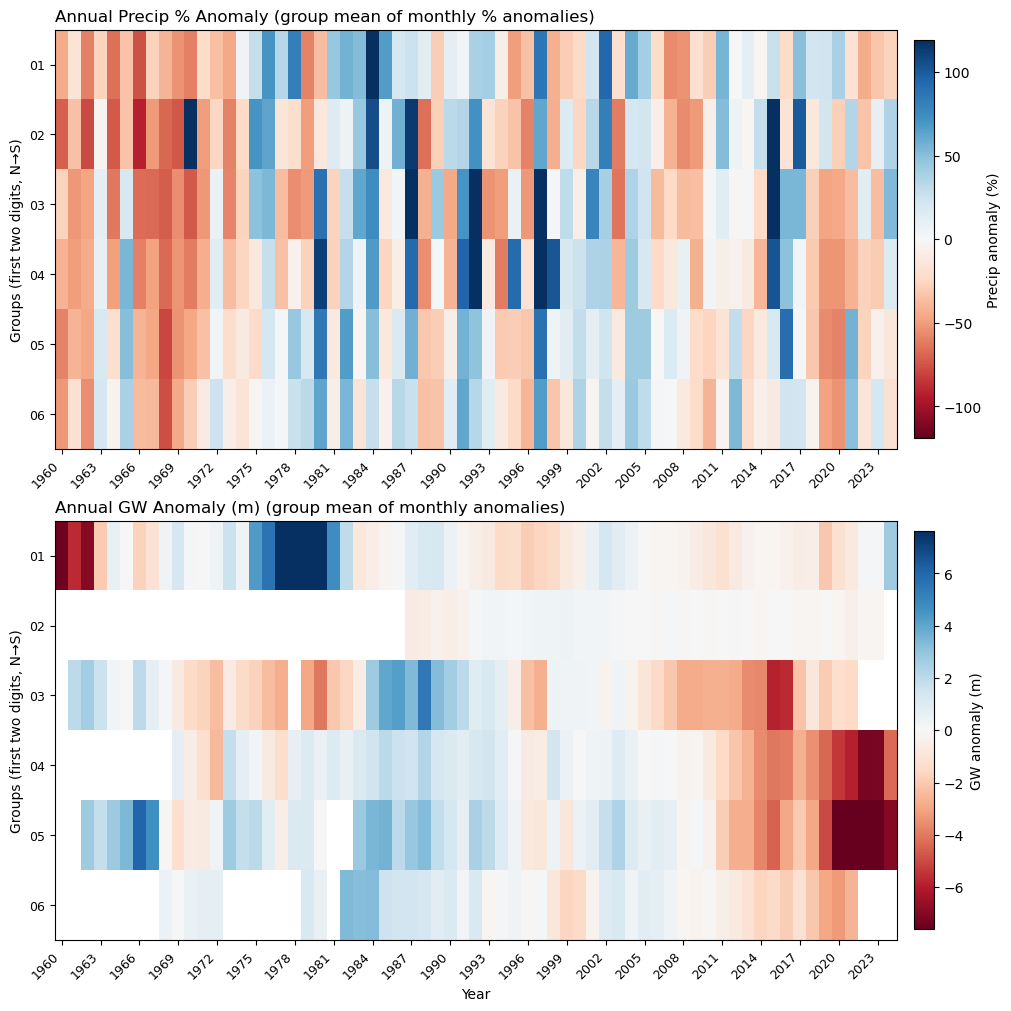

In [ ]:

# -------------------- Load raw precipitation to compute climatology --------------------
# We need monthly climatology (per month-of-year, per well) to convert anomalies to %
raw_candidates = [
    root + '/data/gw_wo_p_et_series_combined/wells_pr.csv',
]
pr_raw_path = next((p for p in raw_candidates if os.path.exists(p)), None)
if pr_raw_path is None:
    raise FileNotFoundError(
        "Raw precipitation file not found. Needed to compute % anomalies. "
        f"Tried: {raw_candidates}"
    )

pr_raw_all = pd.read_csv(pr_raw_path, parse_dates=['date']).set_index('date')

# -------------------- Filter wells by GW obs count --------------------
gw_counts = gw_m.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= min_obs].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the min_obs criterion.")

# use only wells present in all three datasets
common_wells = [w for w in keep_wells if w in pr_m_mm_anom.columns and w in pr_raw_all.columns]
gw_m = gw_m[common_wells]
pr_m_mm_anom = pr_m_mm_anom[common_wells]
pr_raw_all = pr_raw_all[common_wells]

# -------------------- Helper: group label from well code --------------------
def well_group(code: str) -> str:
    try:
        return f"{int(str(code)[:2]):02d}"
    except Exception:
        return "99"

well_groups = {w: well_group(w) for w in common_wells}
groups_sorted = sorted({well_groups[w] for w in common_wells}, key=lambda x: int(x))

# -------------------- Convert PR anomalies (mm) -> % anomalies (monthly) --------------------
# Monthly climatology of raw precipitation by calendar month (1..12) for each well
# Using the long-term mean per month-of-year
pr_clim_by_month = pr_raw_all.groupby(pr_raw_all.index.month).mean()  # shape (12, n_wells); index=1..12

# Align monthly climatology to each timestamp in the anomaly dataframe
clim_aligned = pr_clim_by_month.loc[pr_m_mm_anom.index.month].set_index(pr_m_mm_anom.index)

# % anomaly = 100 * (anomaly_mm / climatology_mm). Guard against divide-by-zero.
pr_m_pct_anom = 100.0 * pr_m_mm_anom.divide(clim_aligned).replace([np.inf, -np.inf], np.nan)

# -------------------- Monthly → Annual aggregation (mean over months in year) --------------------
gw_y = gw_m.resample('A-DEC').mean()            # annual mean of monthly GW anomalies (m)
pr_y_pct = pr_m_pct_anom.resample('A-DEC').mean()  # annual mean % anomaly

gw_y.index = gw_y.index.year
pr_y_pct.index = pr_y_pct.index.year

# shared years for a common X axis
years = sorted(set(gw_y.index).intersection(set(pr_y_pct.index)))
gw_y = gw_y.loc[years]
pr_y_pct = pr_y_pct.loc[years]

# -------------------- Aggregate across wells within each group (mean across wells) --------------------
gw_y.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in gw_y.columns], names=['group', 'well'])
pr_y_pct.columns = pd.MultiIndex.from_tuples([(well_groups[c], c) for c in pr_y_pct.columns], names=['group', 'well'])

gw_grp = gw_y.groupby(level='group', axis=1).mean()
pr_grp_pct = pr_y_pct.groupby(level='group', axis=1).mean()

# Reindex columns to consistent north→south order; ensure same set of groups
all_groups = sorted(set(gw_grp.columns).union(set(pr_grp_pct.columns)), key=lambda x: int(x))
gw_grp = gw_grp.reindex(columns=all_groups)
pr_grp_pct = pr_grp_pct.reindex(columns=all_groups)

# -------------------- Build matrices for heatmaps --------------------
year_vals = np.array(years)
group_labels = all_groups

gw_mat = gw_grp.values.T                     # (n_groups, n_years)
pr_mat_pct = pr_grp_pct.values.T             # (n_groups, n_years)  in %

# -------------------- Color scaling (symmetric around 0, robust) --------------------
def robust_sym_norm(arr, pct=98):
    a = np.abs(arr[np.isfinite(arr)])
    m = np.percentile(a, pct) if a.size else 1.0
    if m == 0: m = 1.0
    return TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

# independent scaling for each panel (keep as you had)
pr_norm = robust_sym_norm(pr_mat_pct)
gw_norm = robust_sym_norm(gw_mat)

# -------------------- Plot (constrained layout, no tight_layout) --------------------
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)

# Precip (% anomalies, top)
ax_pr = fig.add_subplot(gs[0, 0])
im_pr = ax_pr.imshow(
    pr_mat_pct, aspect='auto', interpolation='nearest', cmap='RdBu', norm=pr_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5, len(group_labels) - 0.5, -0.5]
)
ax_pr.set_title('Annual Precip % Anomaly (group mean of monthly % anomalies)', loc='left')
ax_pr.set_ylabel('Groups (first two digits, N→S)')

if len(year_vals) > 20:
    step = max(1, len(year_vals) // 20)
    xticks = year_vals[::step]
else:
    xticks = year_vals
ax_pr.set_xticks(xticks)
ax_pr.set_xticklabels(xticks, rotation=45, ha='right', fontsize=9)

ax_pr.set_yticks(np.arange(len(group_labels)))
ax_pr.set_yticklabels(group_labels, fontsize=9)

cb_pr = fig.colorbar(im_pr, ax=ax_pr, location='right', pad=0.02, shrink=0.95)
cb_pr.set_label('Precip anomaly (%)')

# Groundwater (absolute anomalies, bottom)
ax_gw = fig.add_subplot(gs[1, 0], sharex=ax_pr, sharey=ax_pr)
im_gw = ax_gw.imshow(
    gw_mat, aspect='auto', interpolation='nearest', cmap='RdBu', norm=gw_norm,
    extent=[year_vals.min() - 0.5, year_vals.max() + 0.5, len(group_labels) - 0.5, -0.5]
)
ax_gw.set_title('Annual GW Anomaly (m) (group mean of monthly anomalies)', loc='left')
ax_gw.set_xlabel('Year')
ax_gw.set_ylabel('Groups (first two digits, N→S)')
ax_gw.set_xticks(xticks)
ax_gw.set_xticklabels(xticks, rotation=45, ha='right', fontsize=9)
ax_gw.set_yticks(np.arange(len(group_labels)))
ax_gw.set_yticklabels(group_labels, fontsize=9)

cb_gw = fig.colorbar(im_gw, ax=ax_gw, location='right', pad=0.02, shrink=0.95)
cb_gw.set_label('GW anomaly (m)')
